## Adiabatic parameters from neutron's paths
Emma Klemets   
Nov. 2022   
Full documentation of the theory can be found at: https://www.overleaf.com/read/rfkkhhwwfjct

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from numpy import linalg as LA
import pandas as pd
import seaborn as sns

In [2]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

In [3]:
#3.11 in Pierre
def K_equ_dbdt(B, dbdt):
    return gamma_n*B**2 / dbdt

#equation 2 in the CDR - Sect 4.1 for the value of k
#3.12 in Pierre
def K_equ_dbdx(B, db_perpdx, v_n):
    return gamma_n*B**2 / (v_n*db_perpdx)

#3.14 in Pierre
def K_equ3_14(v_vec, B_1, B_2, r_1, r_2):
    #what to use for this value of the field?
    B = LA.norm(B_1)
    
    v_n = LA.norm(v_vec)
    B_1_norm = LA.norm(B_1)
    B_2_norm = LA.norm(B_2)
    
    #the angle that the field changes by
    if B_1_norm == 0 or B_2_norm == 0: # if either 0 feild == bad, k=0
        k = 0
    elif B_1_norm*B_2_norm == 0:  #not so sure about this one
        '''
        if either norm is 0, then bad
        '''
#         print(B_1_norm, B_2_norm)
        k = 0 #-np.inf
    else:
        theta = np.arccos(B_1@B_2/(B_1_norm*B_2_norm))
    
        #the distance for that change
        delta_distance = LA.norm(r_2 - r_1)

        #k calculation
        k = gamma_n*B*delta_distance / (v_n * theta)

    return k

[11-10 8:41 a.m.] Jeffery W. Martin
Also, just to set a scale for this problem:

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the UCN moves in a straight line at 8 m/s.

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the magnetic field rotates by 90 degrees during this time.

[11-10 8:43 a.m.] Jeffery W. Martin
Actually, let's say it rotates by 90 degrees in the course of 1 m of travel by the neutron.

[11-10 8:43 a.m.] Jeffery W. Martin
And let's say the value of the field is typically 1 mT.

[11-10 8:43 a.m.] Jeffery W. Martin
For this situation, I get k=15,000



In [4]:
#trying out Jeff's numbers, matches up
v_vec = np.array([8, 0, 0]) #m/s

B_1 = np.array([1, 0, 0])*1e-6 #=1uT
B_2 = np.array([0, 1, 0])*1e-6 #=1uT
r_1 = np.array([0, 0, 0]) 
r_2 = np.array([1, 0, 0]) #dx = 1m

K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

14.582346536127906

In [5]:
#calculates the k value for a 90 degrees turn with a uniform magnitude magnetic field (B)
#for a given neutron speed (vn) and distance of the turn (dx) 
def pseudoScalar_K_equ3_14(vn, B, dx):
    
    v_vec = np.array([vn, 0, 0])
    B_1 = np.array([B, 0, 0])
    B_2 = np.array([0, B, 0])
    r_1 = np.array([0, 0, 0]) 
    r_2 = np.array([dx, 0, 0])

    return K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

In [6]:
#scalar imputs for simplicity
#speed of your neutrons
vn = 8 #/ms
#magnitude of your magnetic field
B = 500*1e-6
#distance travels during the turn
dx = .2

pseudoScalar_K_equ3_14(vn, B, dx)

1458.234653612791

In [7]:
n = 55
B_arr = np.linspace(1e-6, 550e-6, n)
dx_arr = np.linspace(.01, .55, n)

k_array = np.empty((0, 3))
for B in B_arr:
    for dx in dx_arr:
        val = pseudoScalar_K_equ3_14(vn, B, dx)
        k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
# print(k_array)

In [8]:
df = pd.DataFrame(k_array, columns = ['B','dx','k'])
df = df.pivot("B", "dx", "k")

df = df.reindex(index=df.index[::-1])
# df

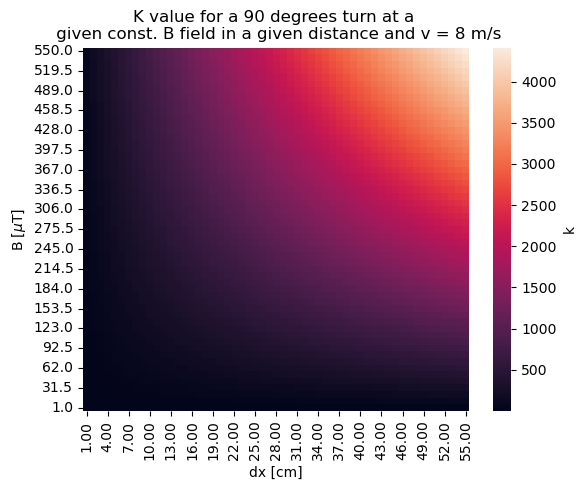

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
q = sns.heatmap(df)#xticklabels=10, yticklabels=10, cmap=new_purple, linewidths=0, square=True)
    
ax.collections[0].colorbar.set_label("k")

# Add axis tick labels
# ax.set_xticks(np.arange(len(df.columns)), 
#               labels=np.round(df.columns, decimals=3))

# ax.set_yticks(np.arange(len(df.index)), 
#               labels=np.round(df.index*1e6, decimals=2))

# format text labels
fmt = '{:0.2f}' #dx
xticklabels = []
for item in ax.get_xticklabels():
    # print(item.get_text())
    item.set_text(fmt.format(float(item.get_text())*100))
    xticklabels += [item]
    
fmt = '{:0.1f}'
#B
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())*1e6))
    yticklabels += [item]
    
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)#,  rotation=0)

ax.set_xlabel("dx [cm]")
ax.set_ylabel("B [$\mu$T]")

ax.set_title("K value for a 90 degrees turn at a \n given const. B field in a given distance and v = 8 m/s")#, size=20)

fig.tight_layout()
plt.show()

# An idea of the B field
We have a lot of different regions, with different things that will affect the field:
 * SCM - well mapped
 * SSA - ?
 * Sheilding blocks - very much going to change
 * AMC - still in development, 
 * Background cylotron field - dipole analytic model
 * etc
 
 We need to start simpler than this.
 
 <img src="./Photos/guidingFieldDiagram.jpg" width="700" />

## Analytic Dipole model

The background field from the cylotron has been previously modeled usin an analytic dipole model for the potential, $\Phi_{dipole}$ and then using $\vec{B} = -\nabla \Phi_{dipole}$ to get the resulting magnetic field.

From the TUCAN 2022 status report: 12.1.3 Recent progress
Refined FEA simulation of the background magnetic field and compensating fields.

> The cyclotron stray field was approximated by a dipole field originated at (x, y) ≈ (−16m,−11m) away
from the center of the MSR and implemented to the FEA simulation.
- this is done with the center of the MSR as the origin
- only reproduces the major features of the field well for z > 0, and around the MSR

In [10]:
from sympy.vector import CoordSys3D, gradient

In [40]:
"""
Using the dipole model for the potential, calculates the B field for a given
region of points
Input:
    x_input, y_input, z_input: 1D arrays of points for each dimension of the region
Output:
    B_dipole: pd data frame with columes: ['x', 'y', 'z', 'Bx', 'By', 'Bz', 'B']
    - distances are in m, field is in T
"""
def DipoleFeild(x_input, y_input, z_input):
    #define a coordinate system to use
    R = CoordSys3D('F_{MSR}') 
    M = sp.symbols("M_v")
    x0,y0, z0 = sp.symbols(" x_0  y_0 z_0")
    x,y, z = sp.symbols(" x  y z")

    #the dipole function for the scalar potential
    Phi = sp.Function("\Phi_{dipole}")(M, R.x, x0,R.y, y0,R.z, z0 )
    Phi_funct = -M*(R.z-z0) / ((R.x-x0)**2 + (R.y-y0)**2 +(R.z-z0)**2)**(3/2)

    # The fit parameters from Takashi's work
    M_fit = -1.577 #T·m^3
    x0_fit = -16.03 #m
    y0_fit = -10.52 #m
    z0_fit = 0.531 #m 

    Phi_funct = Phi_funct.subs(M, M_fit).subs(x0, x0_fit).subs(y0, 
                            y0_fit).subs(z0, z0_fit) 

    # Phi_funct
    B = sp.Function("\\vec{B}_{dipole}")(R.x, R.y, R.z)
    #take the -gradient of the scalar potential
    B_funct = -1*gradient(Phi_funct).simplify()
    # display(sp.Eq(B, B_funct, evaluate=False))
    B_funct = B_funct.to_matrix(R)
    
    #convert each component back to a normal function to evalute numerically
    f_x = B_funct[0].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_x = sp.lambdify((x, y, z), f_x)

    f_y = B_funct[1].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_y = sp.lambdify((x, y, z), f_y)

    f_z = B_funct[2].subs(R.x, x).subs(R.y, y).subs(R.z, z)
    B_z = sp.lambdify((x, y, z), f_z)
    
    # get a meshgrid of the region we actually want data for (in meters)
    xx, yy, zz = np.meshgrid(x_input, y_input, z_input, copy=True)

    #get the B field component in each position
    B_Xeval = B_x(xx, yy, zz)
    B_Yeval = B_y(xx, yy, zz)
    B_Zeval = B_z(xx, yy, zz)

    NT = np.product(xx.shape)
    # print(NT)

    #convert into a pandas data frame for use
    data = { #coords in m, B in T
        "x": np.reshape(xx,NT),
        "y": np.reshape(yy,NT),
        "z": np.reshape(zz,NT), 
        "Bx": np.reshape(B_Xeval,NT), 
        "By": np.reshape(B_Yeval,NT), 
        "Bz": np.reshape(B_Zeval,NT), 
        "B": np.reshape(np.sqrt(B_Xeval**2 + B_Yeval**2 + B_Zeval**2),NT), 
    }

    B_dipole = pd.DataFrame(data=data)
    return B_dipole

In [39]:
# get a meshgrid of the region we actually want data for (in meters)
n = 20
DimX = np.linspace(-1, 1, n)
DimY = np.linspace(-2, 0, n)
DimZ = np.linspace(-0.6, 0.6, n)

#and use the analytic model to get the field for the given points
B_dipole = DipoleFeild(DimX, DimY, DimZ)
B_dipole.columns

Index(['x', 'y', 'z', 'Bx', 'By', 'Bz', 'B'], dtype='object')

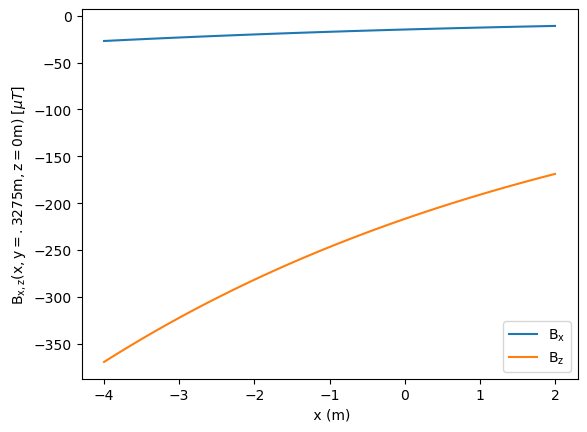

In [36]:
## A check, comparing to Takashi's work
#x, y=.3275, z=0
# Bx & B_z

DimX = np.linspace(-4, 2, 100)
DimY = np.array([.3275])
DimZ = np.array([0])

B_dipole_line = DipoleFeild(DimX, DimY, DimZ)

plt.plot(B_dipole_line.x, B_dipole_line.Bx*1e6, label='$\mathsf{B_x}$')
plt.plot(B_dipole_line.x, B_dipole_line.Bz*1e6, label='$\mathsf{B_z}$')
plt.xlabel(' x (m)')
plt.ylabel('$\mathsf{B_{x,z}(x,y=.3275 m, z=0 m)} ~ [\mu T]$')
plt.legend()

plt.show()

In [47]:
#importing data from my 2022 fall mapping
colNames = ['x', 'y', 'z', 'B_x', 'B_y', 'B_z']
#uses cm and uT already
file_22 = "../MesonMagMapping/Fall_2022/data_export/map_referencedMSR_fall2022_together_interp50.txt"
data_myMapping2022 = pd.read_csv(file_22, comment='#', sep='\t', names=colNames)
#cutting the data to only the region no more than 80 cm below the center of the MSR
data_myMapping2022 = data_myMapping2022[data_myMapping2022.z > -80]


In [24]:
import sys, os
sys.path.insert(1, '../MesonMagMapping/PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
from stl import mesh
from mpl_toolkits import mplot3d

C:\Users\Emma\AppData\Local\Temp\ipykernel_6520\2705562952.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


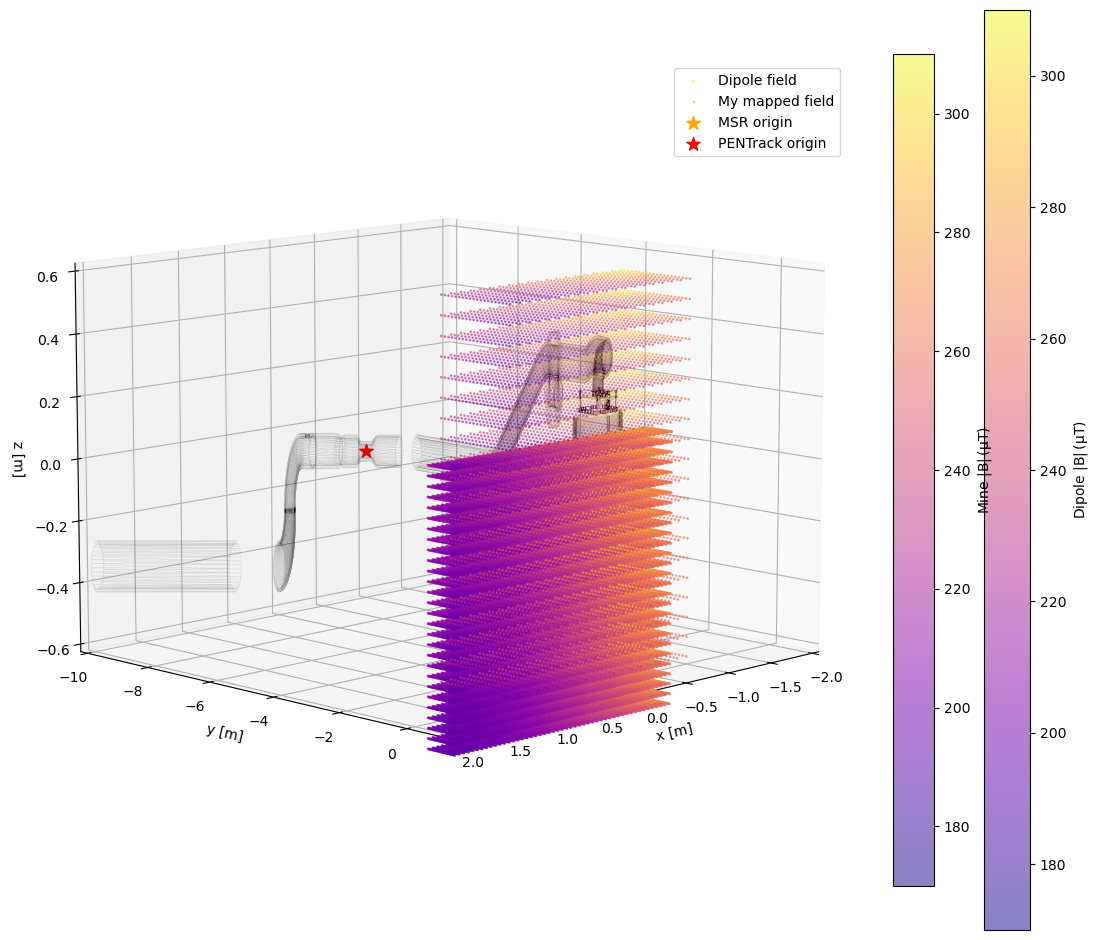

In [42]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# plt.title("2019 Magnetic field mapping", pad=-10)

# B1 = np.sqrt(data1[2]['B_x']**2 + data1[2]['B_y']**2 + data1[2]['B_z']**2 )*100 #muT
Q_dipole = axes.scatter(B_dipole['x'], B_dipole['y'], B_dipole['z'],
                            c=B_dipole['B']*1e6, s=1, alpha=0.5, cmap='plasma', label="Dipole field", 
                       vmin=170, vmax=310)
# cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,
#                     0.02,axes.get_position().height])
# fig.colorbar(Q, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cbar = fig.colorbar(Q_dipole, label='Dipole $\mathsf{|B|\,(\mu T)}$', fraction=0.046)#, cax=cax)

B_myMapping2022 = np.sqrt(data_myMapping2022.B_x**2 + data_myMapping2022.B_y**2 + data_myMapping2022.B_z**2)
Q_myMapping = axes.scatter(data_myMapping2022['x']/100, data_myMapping2022['y']/100, 
                           data_myMapping2022['z']/100, c=B_myMapping2022, s=1, 
                           alpha=0.5, cmap='plasma', label="My mapped field", 
                           vmin=170, vmax=310)

cbar = fig.colorbar(Q_myMapping, label='Mine $\mathsf{|B|\,(\mu T)}$', fraction=0.046)#, cax=cax)
     
#loads all the file I have in this folder as STLs
STLpath = '../MesonMagMapping/PrettyPlotTools/STLsToGraph_F_MSR'
stl_array = os.listdir(STLpath)

axes.scatter(0, 0, 0, marker="*", s=100, color="orange", label="MSR origin")
axes.scatter(0.223, -6.489, 0, marker="*", s=100, color="red", 
             label="PENTrack origin")

for STLfile in stl_array:
#     print(STLfile)
    ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
axes.view_init(elev=10., azim=45)
# axes.view_init(elev=90., azim=-90) #top view
axes.set_xlim(-2, 2)
axes.set_ylim(-10, 1)
axes.set_zlim(-0.6, 0.6)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

## SCM

In [26]:
import bz2

In [60]:
file = "../UCN_work/PENTrackAnalysis/SCMatOriginAlongX_hires_CGS.table.bz2"

data = np.loadtxt(file, skiprows=8)#, dtype=None)
# print(data)

stream = bz2.BZ2File(file)
for i in range(1,10):
    line = stream.readline()
    print(line)
    
# cols = ['X' ,'Y', 'Z', 'BX G', 'BY G', 'BZ G']
cols = ['x', 'y', 'z', 'B_x', 'B_y', 'B_z']
#this data is in cm & G
B_SCM = pd.DataFrame(data=data, columns=cols)
# display(B_SCM)

b' 1001 36 36 2\n'
b' 1 X [CM]\n'
b' 2 Y [CM]\n'
b' 3 Z [CM]\n'
b' 4 BX [GAUSS]\n'
b' 5 BY [GAUSS]\n'
b' 6 BZ [GAUSS]\n'
b' 0\n'
b'  -200.000000000      -7.00000000000      -7.00000000000     -0.947158851820     -0.295569362365E-01 -0.843140307424E-01\n'


C:\Users\Emma\AppData\Local\Temp\ipykernel_6520\1392077274.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


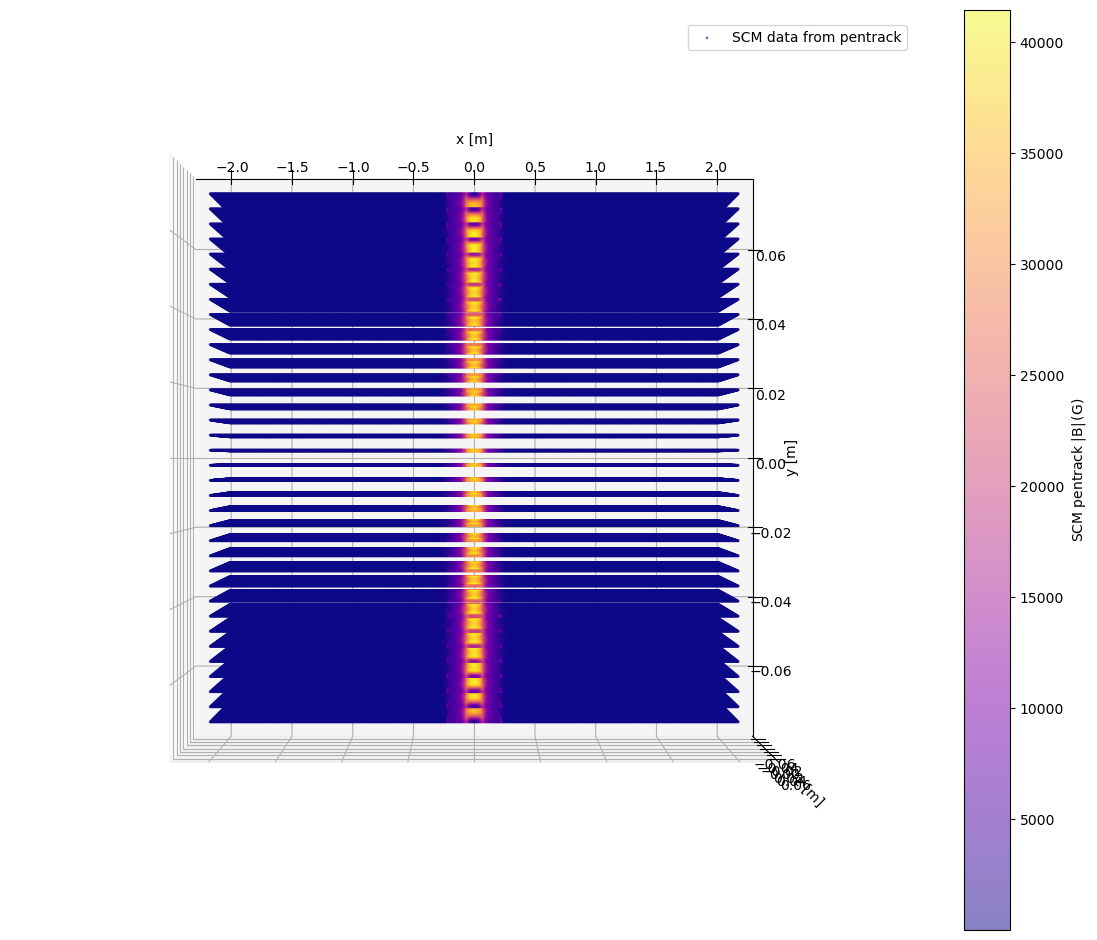

In [87]:
# %matplotlib inline
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

axes.view_init(elev=90., azim=-90) #top view
B_SCM_mag = np.sqrt(B_SCM['B_x']**2 + B_SCM['B_y']**2 + B_SCM['B_z']**2)
Q_SCM_Pen= axes.scatter(B_SCM['x']/100, B_SCM['y']/100, B_SCM['z']/100, c=B_SCM_mag, s=1, 
                           alpha=0.5, cmap='plasma', label="SCM data from pentrack")
                           # vmin=170, vmax=310)
cbar = fig.colorbar(Q_SCM_Pen, label='SCM pentrack $\mathsf{|B|\,(G)}$', fraction=0.046)#, cax=cax)
axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

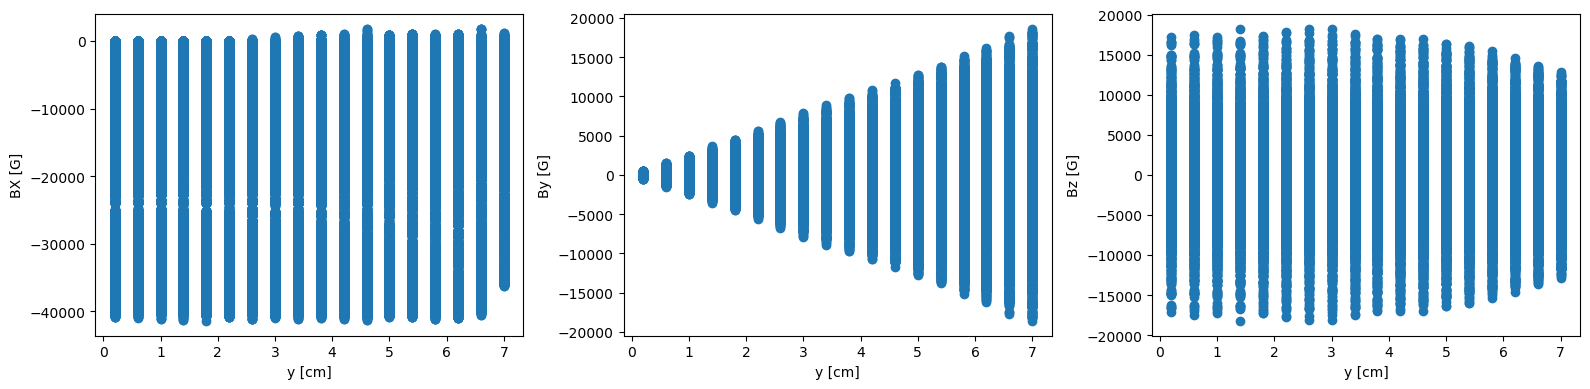

In [120]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))

B_SCM_cut = B_SCM[B_SCM.y > 0]

axs[0].plot(B_SCM_cut.y, B_SCM_cut.B_x, ls="", marker="o")
axs[0].set_ylabel('BX [G]')
axs[0].set_xlabel('y [cm]')

axs[1].plot(B_SCM_cut.y, B_SCM_cut.B_y, ls="", marker="o")
axs[1].set_ylabel('By [G]')
axs[1].set_xlabel('y [cm]')

axs[2].plot(B_SCM_cut.y, B_SCM_cut.B_z, ls="", marker="o")
axs[2].set_ylabel('Bz [G]')
axs[2].set_xlabel('y [cm]')

# plt.suptitle("Adiabatic parameter vs position")
plt.tight_layout()
plt.show()

In [123]:
def PentrackToMSR(Data):

    Data_Copy = Data.copy()
    df_data = rotateBData(Data_Copy, np.zeros(3), -110)
    
    # Rotate -110 deg about z axis, 
    # The move X=+0.223, Y = -6.489 m
    x_off = +22.3 # cm 
    y_off = - 648.9 # cm 
    
    df_data.x +=x_off
    df_data.y +=y_off
    
    return df_data
    
def rotateBData(df_data, origin, angle):
    data_pos = rotate3D(df_data[['x', 'y', 'z']].values, origin=origin, degrees=angle)
    
    #gotta check this part makes sense
    data_B = rotate3D(df_data[['B_x', 'B_y', 'B_z']].values, origin=origin, degrees=angle)
    print(f"Rotation of {angle} degrees")
    
    df_data_rot = pd.DataFrame(data_pos, columns=['x', 'y', 'z'])
    df_data_rot[['B_x', 'B_y', 'B_z']] = data_B
    
    return df_data_rot

def rotate3D(p, origin=(0, 0, 0), degrees=0):
    #3D rotation
    angle = np.deg2rad(degrees)
    
    R = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle),  np.cos(angle), 0],
                  [0, 0, 1]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    A = np.squeeze((R @ (p.T-o.T) + o.T).T)
    return A


In [122]:
B_SCM_FMSR = PentrackToMSR(B_SCM)
# B_SCM_FMSR

# B_SCM_FMSR.compare(B_SCM, keep_shape=True)

Rotation of -110 degrees


C:\Users\Emma\AppData\Local\Temp\ipykernel_6520\1210067050.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


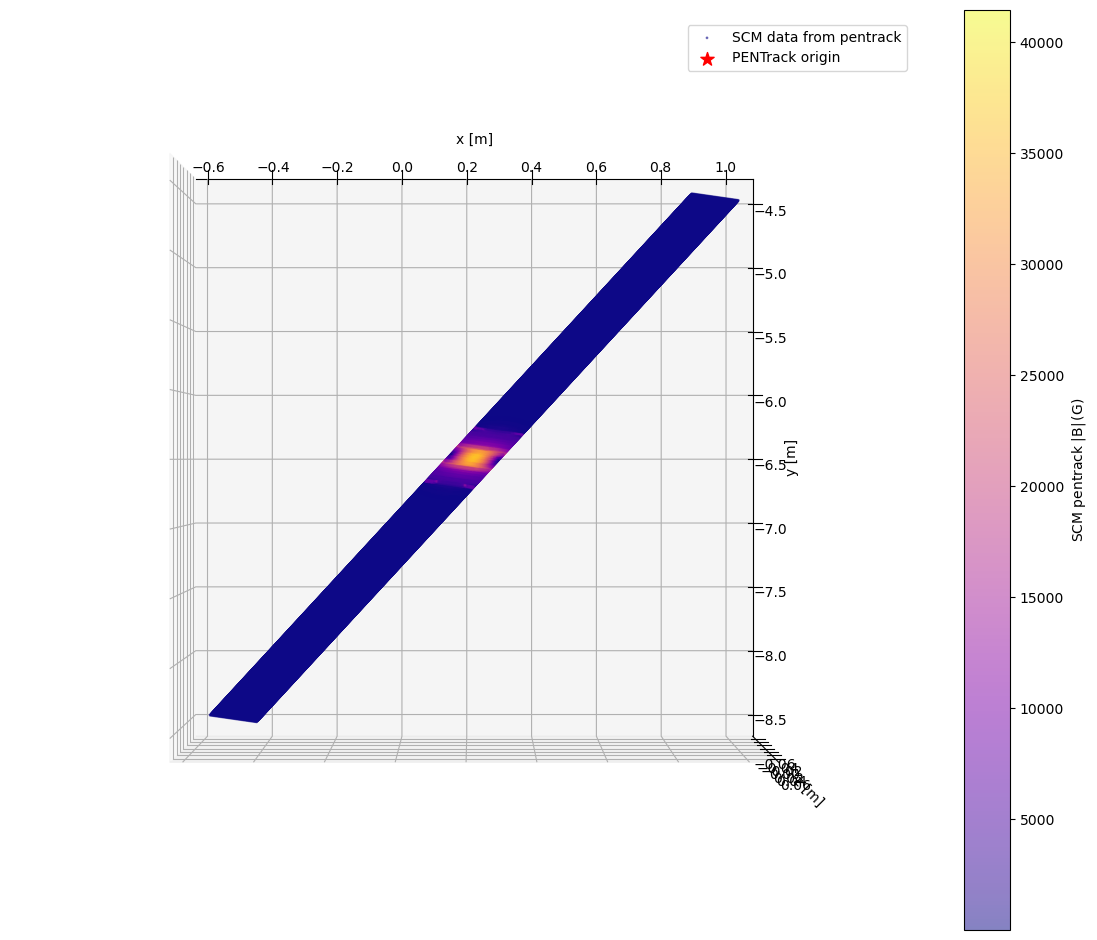

In [112]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

axes.view_init(elev=90., azim=-90) #top view

B_SCM_mag = np.sqrt(B_SCM_FMSR['B_x']**2 + B_SCM_FMSR['B_y']**2 + B_SCM_FMSR['B_z']**2)
Q_SCM_Pen= axes.scatter(B_SCM_FMSR['x']/100, B_SCM_FMSR['y']/100, B_SCM_FMSR['z']/100, c=B_SCM_mag, s=1, 
                           alpha=0.5, cmap='plasma', label="SCM data from pentrack")
                           # vmin=170, vmax=310)
cbar = fig.colorbar(Q_SCM_Pen, label='SCM pentrack $\mathsf{|B|\,(G)}$', fraction=0.046)#, cax=cax)

#loads all the file I have in this folder as STLs
STLpath = '../MesonMagMapping/PrettyPlotTools/STLsToGraph_F_MSR'
stl_array = os.listdir(STLpath)

# axes.scatter(0, 0, 0, marker="*", s=100, color="orange", label="MSR origin")
axes.scatter(0.223, -6.489, 0, marker="*", s=100, color="red", 
             label="PENTrack origin")

# for STLfile in stl_array:
# #     print(STLfile)
#     ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
# axes.set_xlim(-2, 2)
# axes.set_ylim(-10, 1)
# axes.set_zlim(-0.6, 0.6)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

In [128]:
os.listdir('referenceMaps/tucan-magnetics-SCM-mapping-main/SCM_mapping_20191120/')

filePath_SCM_T = 'referenceMaps/tucan-magnetics-SCM-mapping-main/'

In [129]:
df0 = pd.read_csv(f'{filePath_SCM_T}SCM_mapping_20191120/20191120_1406_RUN1_200A_center_avg_corr.csv', 
                 names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])
df1 = pd.read_csv(f'{filePath_SCM_T}SCM_mapping_20191120/20191120_1422_RUN2_100A_center_avg_corr.csv',
                 names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])
df2 = pd.read_csv(f'{filePath_SCM_T}SCM_mapping_20191120/20191120_1447_RUN3_200A_dZ_-25mm__avg_corr.csv',
                 names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])
# df3 = pd.read_csv('../20191116_SCM/SCM_map/20191116_200A_yoke_fine/20191116_1708_fine_scan_200A_no_offset_avg_.csv')
# df3_ = pd.read_csv('../20191116_SCM/SCM_map/20191116_200A_yoke_fine/20191116_1708_fine_scan_200A_no_offset_avg.csv',
#                    names=['cycle','time_s', 'time_e','X','Y','Z', 'B_X','dB_X','B_Y','dB_Y','B_Z','dB_Z'])



In [180]:
df_all = pd.concat([df0, df2])

#it looks like some of the axis are flipped
# df02 = df2.append(df0)
# for Xi in Xs:
#     ax1[0].plot(-df02_X[df02_X['X']==Xi]['Y'], df02_X[df02_X['X']==Xi]['B_Z'], 'o', label='z=%.1f' %Xi, markersize=1)
#     ax1[1].plot(-df02_X[df02_X['X']==Xi]['Y'], -df02_X[df02_X['X']==Xi]['B_Y'], 'o', label='z=%.1f' %Xi, markersize=1)
#     ax1[2].plot(-df02_X[df02_X['X']==Xi]['Y'], df02_X[df02_X['X']==Xi]['B_X'], 'o', label='z=%.1f' %Xi, markersize=1)

#flip sign of Y
df_all.Y = -df_all.Y 
df_all.B_Y = -df_all.B_Y

#switch X and z coods
Xsave = df_all.X
BXsave = df_all.B_X

df_all.X = df_all.Z
df_all.B_X = df_all.B_Z

df_all.Z = Xsave
df_all.B_Z = BXsave

# df_all

df02_X = df_all[df_all.Z==0]
df02_Z = df_all[df_all.X==0]

xz_0 = np.unique(df0[['X', 'Z']], axis=0)
xz_2 = np.unique(df2[['X', 'Z']], axis=0)
Xs = np.unique(df02_X['X'], axis=0)
Zs = np.unique(df02_Z['Z'], axis=0)
Ys = np.unique(df_all['Y'], axis=0)


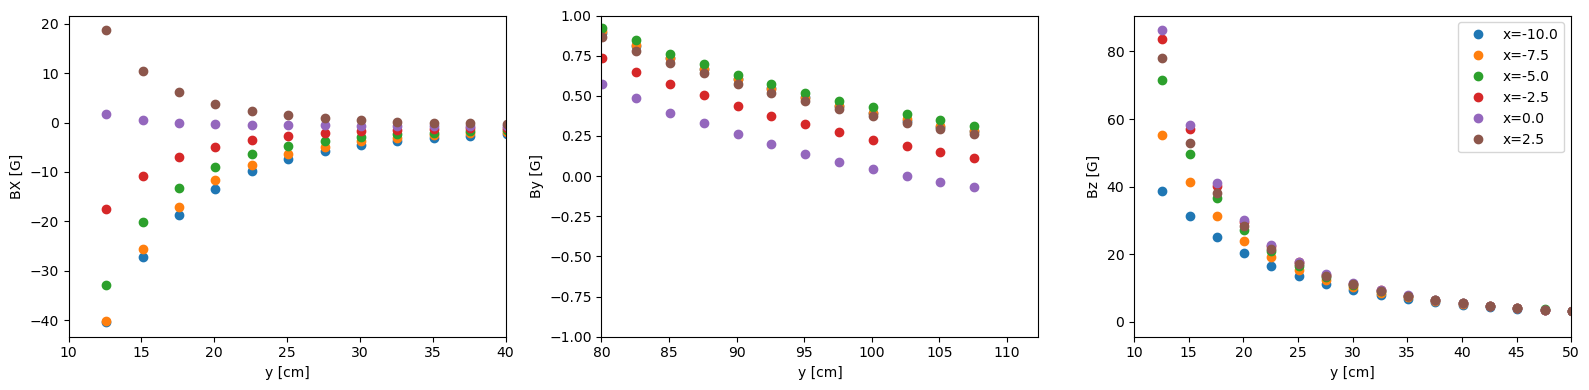

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))

# [df_all.X==10]
# axs[0].plot(df_all.Y, df_all.B_X, ls="", marker="*", color="black")
for Zi in Xs:
    axs[0].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_X'], 'o', label='x=%.1f' %Zi, lw=.8)#,markersize=1)
    axs[1].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_Y'], 'o', label='x=%.1f' %Zi, lw=.8)#,markersize=1)
    axs[2].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_Y'], 'o', label='x=%.1f' %Zi ,lw=.8)#,markersize=1)

axs[0].set_ylabel('BX [G]')
axs[0].set_xlabel('y [cm]')
axs[0].set_xlim(10, 40)

# axs[1].plot(df_all.Y, df_all.B_Y, ls="", marker="o")
axs[1].set_ylabel('By [G]')
axs[1].set_xlabel('y [cm]')
axs[1].set_xlim(80)
axs[1].set_ylim(-1, 1)

# axs[2].plot(df_all.Y, df_all.B_Z, ls="", marker="o")
axs[2].set_ylabel('Bz [G]')
axs[2].set_xlabel('y [cm]')

axs[2].set_xlim(10, 50)

# plt.suptitle("Adiabatic parameter vs position")
plt.tight_layout()
plt.legend()
plt.show()

C:\Users\Emma\AppData\Local\Temp\ipykernel_6520\2221728399.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


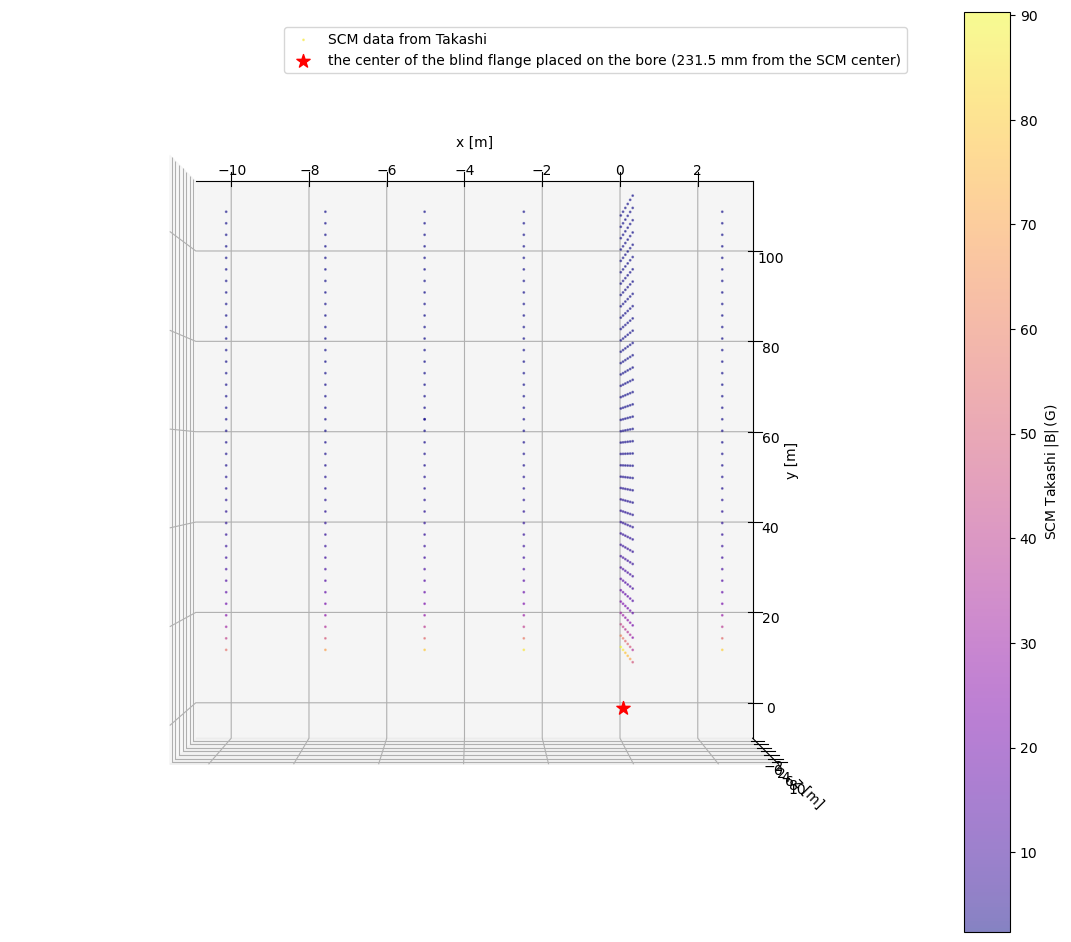

In [186]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

axes.view_init(elev=90., azim=-90) #top view

B_SCM_mag = np.sqrt(df_all['B_X']**2 + df_all['B_Y']**2 + df_all['B_Z']**2)
Q_SCM_Pen= axes.scatter(df_all['X'], df_all['Y'], df_all['Z'], c=B_SCM_mag, s=1, 
                           alpha=0.5, cmap='plasma', label="SCM data from Takashi")
                           # vmin=170, vmax=310)
cbar = fig.colorbar(Q_SCM_Pen, label='SCM Takashi $\mathsf{|B|\,(G)}$', fraction=0.046)#, cax=cax)

#loads all the file I have in this folder as STLs
STLpath = '../MesonMagMapping/PrettyPlotTools/STLsToGraph_F_MSR'
stl_array = os.listdir(STLpath)

# axes.scatter(0, 0, 0, marker="*", s=100, color="orange", label="MSR origin")
axes.scatter(0, 0, 0, marker="*", s=100, color="red", 
             label="the center of the blind flange placed on the bore (231.5 mm from the SCM center)")

# for STLfile in stl_array:
# #     print(STLfile)
#     ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
# axes.set_xlim(-2, 2)
# axes.set_ylim(-10, 1)
# axes.set_zlim(-0.6, 0.6)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

In [202]:
#Interpolation

x_min, x_max= np.min(df_all.X), np.max(df_all.X)
y_min, y_max= np.min(df_all.Y), np.max(df_all.Y)
z_min, z_max= np.min(df_all.Z), np.max(df_all.Z)

NL = 50 # this defines the number of points for interpolation, default is 50

x_dense, z_dense, y_dense = np.meshgrid(np.linspace(x_min, x_max, NL), 
                        np.linspace(z_min, z_max, NL), np.linspace(y_min,y_max, NL))

#could make a version with arange instead which might make the shifting possible
# di = 0.5
# x_dense, z_dense, y_dense = np.meshgrid(np.arange(x_min, x_max, di), np.arange(z_min, z_max, di), np.arange(y_min,y_max, di))


Bx_rbf = interp.Rbf(df_all.X, df_all.Y, df_all.Z, df_all.B_X, function='cubic', smooth=0)  # default smooth=0 for interpolation
Bx_dense = Bx_rbf(x_dense, y_dense, z_dense)  # not really a function, but a callable class instance

Bz_rbf = interp.Rbf(df_all.X, df_all.Y, df_all.Z, df_all.B_Y, function='cubic', smooth=0)  # default smooth=0 for interpolation
Bz_dense = Bz_rbf(x_dense, y_dense, z_dense)   # not really a function, but a callable class instance

By_rbf = interp.Rbf(df_all.X, df_all.Y, df_all.Z, df_all.B_Z, function='cubic', smooth=0)  # default smooth=0 for interpolation
By_dense = By_rbf(x_dense, y_dense, z_dense)   # not really a function, but a callable class instance

NT = np.product(y_dense.shape)

data = {
    "X": np.reshape(x_dense,NT),
    # "x": np.ones(NT)*x_cut,
    "Y": np.reshape(y_dense,NT),
    "Z": np.reshape(z_dense,NT),
    "B_X": np.reshape(Bx_dense, NT),
    "B_Y": np.reshape(By_dense, NT),
    "B_Z": np.reshape(Bz_dense, NT),
}

df_all_intr = pd.DataFrame(data, columns=['X','Y','Z','B_X','B_Y','B_Z'])
df_all_intr.index.name = 'index'


C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_rbf.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=1.33772e-38): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


In [203]:
df_all_intr

,X,Y,Z,B_X,B_Y,B_Z
index,,,,,,
0,-10.0,12.570000,-2.5,-8.828527e+15,-4.708338e+15,-9.446262e+15
1,-10.0,14.508776,-2.5,-6.842225e+15,-2.978655e+15,-1.489063e+16
2,-10.0,16.447551,-2.5,-3.039197e+15,-7.318418e+15,-5.272766e+15
3,-10.0,18.386327,-2.5,-1.245810e+16,-4.637484e+15,-4.727876e+15
4,-10.0,20.325102,-2.5,-5.739032e+15,-2.477352e+15,-3.548310e+15
...,...,...,...,...,...,...
124995,2.5,99.814898,10.0,-2.077315e+14,1.279781e+15,-1.102282e+15
124996,2.5,101.753673,10.0,3.949316e+14,2.757177e+14,-1.987745e+15
124997,2.5,103.692449,10.0,3.465085e+15,1.500507e+14,1.887858e+15


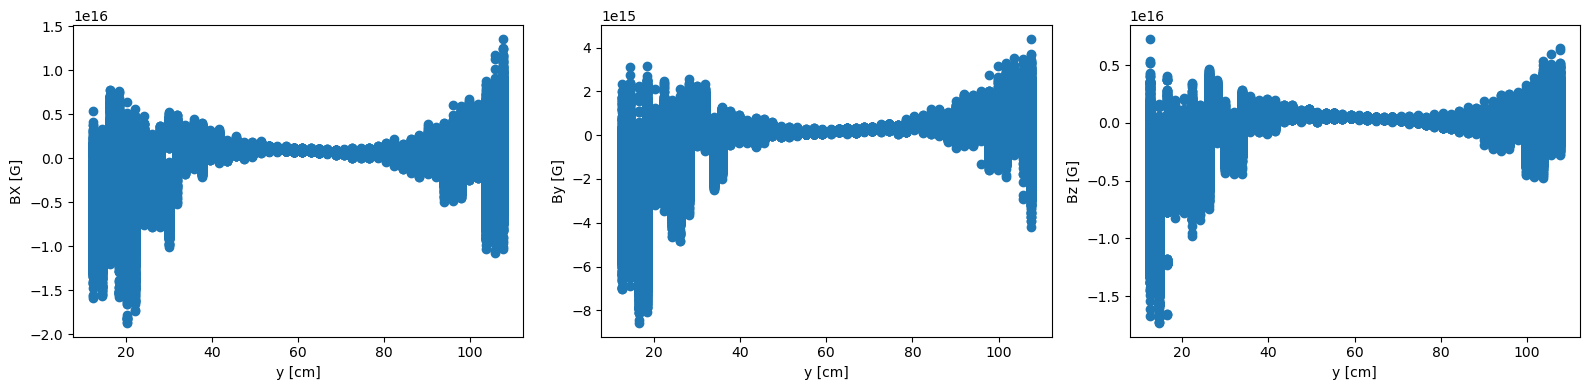

In [204]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))

# [df_all.X==10]
axs[0].plot(df_all_intr.Y, df_all_intr.B_X, ls="", marker="o")#, color="black")
# for Zi in Xs:
#     axs[0].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_X'], 'o', label='x=%.1f' %Zi, lw=.8)#,markersize=1)
#     axs[1].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_Y'], 'o', label='x=%.1f' %Zi, lw=.8)#,markersize=1)
#     axs[2].plot(df02_X[df02_X['X']==Zi]['Y'], df02_X[df02_X['X']==Zi]['B_Y'], 'o', label='x=%.1f' %Zi ,lw=.8)#,markersize=1)

axs[0].set_ylabel('BX [G]')
axs[0].set_xlabel('y [cm]')
# axs[0].set_xlim(10, 40)

axs[1].plot(df_all_intr.Y, df_all_intr.B_Y, ls="", marker="o")
axs[1].set_ylabel('By [G]')
axs[1].set_xlabel('y [cm]')
# axs[1].set_xlim(80)
# axs[1].set_ylim(-1, 1)

axs[2].plot(df_all_intr.Y, df_all_intr.B_Z, ls="", marker="o")
axs[2].set_ylabel('Bz [G]')
axs[2].set_xlabel('y [cm]')

# axs[2].set_xlim(10, 50)

# plt.suptitle("Adiabatic parameter vs position")
plt.tight_layout()
# plt.legend()
plt.show()